**Intelligent Systems for Pattern Recognition Course - Midterm 1**
## Continous Wavelet Decomposition (CWD) - Assignment 3
Giulia Ghisolfi, role number: 664266

Import libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Dataset

In [2]:
DATA_PATH = 'archive/'

PARTICIPANT_NUMBER = 15
SAMPLING_FREQUENCY = 52 # Hz (52 samples per second)

ACTIVITY_LABELS = {
    1: 'Working at Computer',
    2: 'Standing Up, Walking and Going up\down stairs',
    3: 'Standing',
    4: 'Walking',
    5: 'Going Up\Down Stairs',
    6: 'Walking and Talking with Someone',
    7: 'Talking while Standing'
}

Load data:

In [3]:
def load_dataset(participant_number):
    participant_df = pd.read_csv(DATA_PATH + f'{participant_number}.csv', names=[
    'x', 'y', 'z', 'label'], header=None, index_col=0)

    # remouve rows without label
    participant_df = participant_df[participant_df['label'].isin([1, 2, 3, 4, 5, 6, 7])]

    # add activity columns
    participant_df['activity'] = participant_df['label'].apply(lambda x: ACTIVITY_LABELS[x])

    return participant_df

In [22]:
participant_df = load_dataset(participant_number=PARTICIPANT_NUMBER)
participant_df.sample(5) # data from a wearable accelerometer mounted on the chest

,x,y,z,label,activity
78472.0,2055,2501,1968,3,Standing
20686.0,2140,2537,2036,1,Working at Computer
64146.0,2166,2527,2052,4,Walking
79222.0,2048,2676,2112,3,Standing
1006.0,2413,2268,2000,1,Working at Computer


To understand the composition of the dataset, we visualize statistics for each activity:

In [5]:
# create dataframes with statistics for each activity
activity_stats = participant_df.groupby('activity').agg({'label': 'count',
    'x': ['max', 'min', 'mean', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75)]
}).reset_index()
activity_stats.columns = ['activity', 'samples', 'max', 'min', 'mean', 'std', '25%', '50%', '75%']

# add duration of each activity
activity_stats['duration (s)'] = activity_stats['samples']/SAMPLING_FREQUENCY

# add activity label as index
activity_stats['label'] = activity_stats['activity'].apply(lambda x: 
    list(ACTIVITY_LABELS.keys())[list(ACTIVITY_LABELS.values()).index(x)])
activity_stats.set_index('label', inplace=True)
activity_stats.sort_index(inplace=True)

activity_stats

,activity,samples,max,min,mean,std,25%,50%,75%,duration (s)
label,,,,,,,,,,
1,Working at Computer,51600,2775,1531,2100.151996,44.612449,2084.0,2100.0,2118.0,992.307692
2,"Standing Up, Walking and Going up\down stairs",4680,2667,1329,2120.096154,76.323768,2092.0,2121.0,2169.0,90.000000
3,Standing,7910,2496,1701,2070.165487,52.481326,2037.0,2068.0,2098.0,152.115385
4,Walking,17510,2673,1483,2069.023301,56.910953,2035.0,2073.0,2101.0,336.730769
5,Going Up\Down Stairs,3300,2311,1669,2067.623636,46.865840,2040.0,2072.0,2091.0,63.461538
6,Walking and Talking with Someone,1000,2252,1841,2056.015000,46.707755,2026.0,2059.0,2087.0,19.230769
7,Talking while Standing,17500,2386,1722,2069.111200,27.914914,2058.0,2070.0,2082.0,336.538462


### Visualize data

In [6]:
def plot_activity(activity_name, data_df):
    """
    Plots data for a single activity.

    Args:
        activity_name (str): Name of the activity to visualize
        data_df (DataFrame): DataFrame containing the data
    """
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 3), sharex=True)
    plot_axis(ax0, data_df['x'], 'X-Axis')
    plot_axis(ax1, data_df['y'], 'Y-Axis')
    plot_axis(ax2, data_df['z'], 'Z-Axis')
    fig.suptitle(activity_name+' acceleration data')
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, y_values, ax_name):
    """
    Plots a single axis of the accelerometer data.

    Args:
        ax (axes): Instance of matplotlib axes
        y_values (ndarray): List of values to plot
        ax_name (str): _description_
    """
    x_values = np.arange(0, len(y_values) / SAMPLING_FREQUENCY, 1 / SAMPLING_FREQUENCY)
    ax.plot(x_values, y_values, color='r', linewidth=0.5)
    ax.set_ylabel(ax_name)
    ax.set_ylim([min(y_values) - np.std(y_values), max(y_values) + np.std(y_values)])

We plot acceleration data for the 3 axes for each activity. We consider the 7 activities separately, assigning time t=0 at the initial moment of each activity.

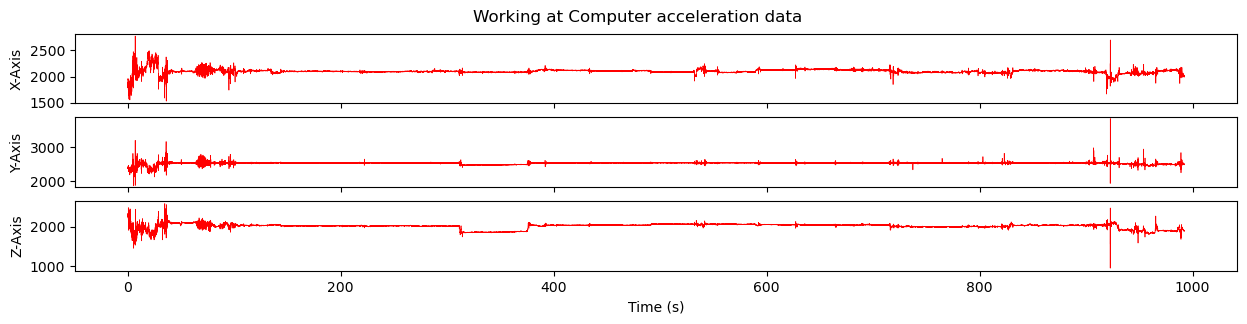

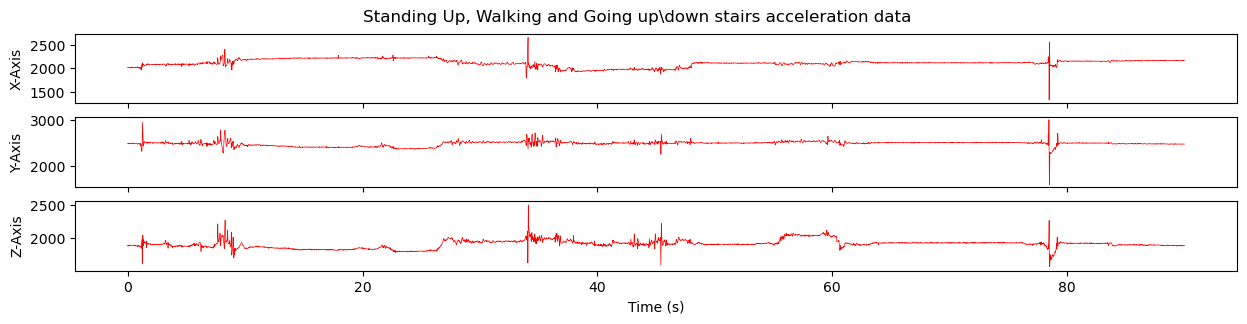

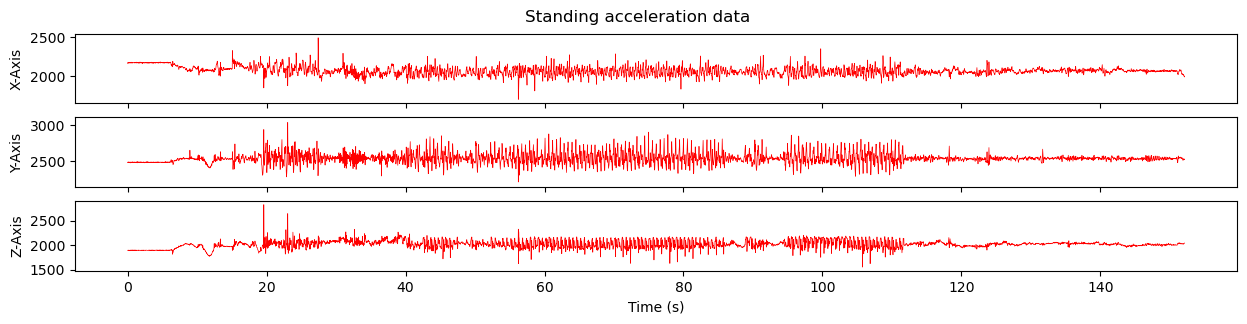

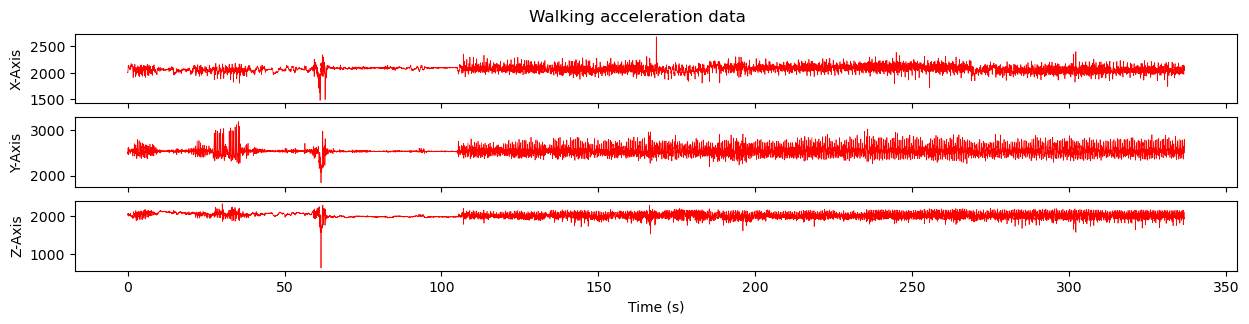

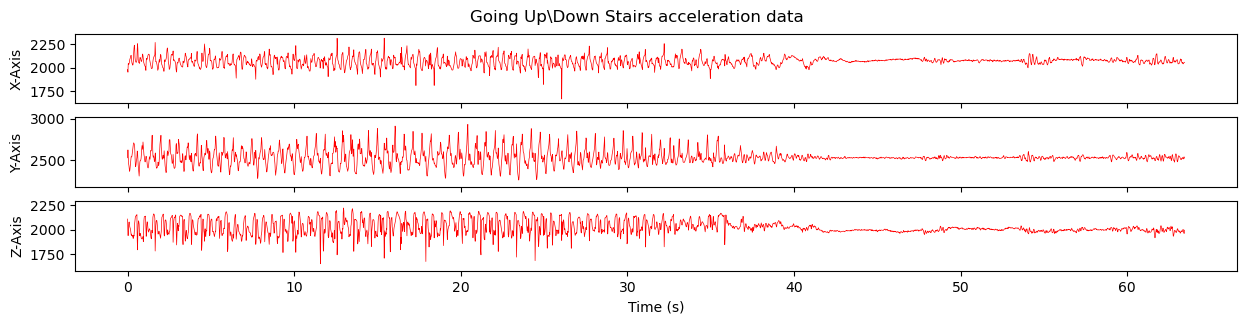

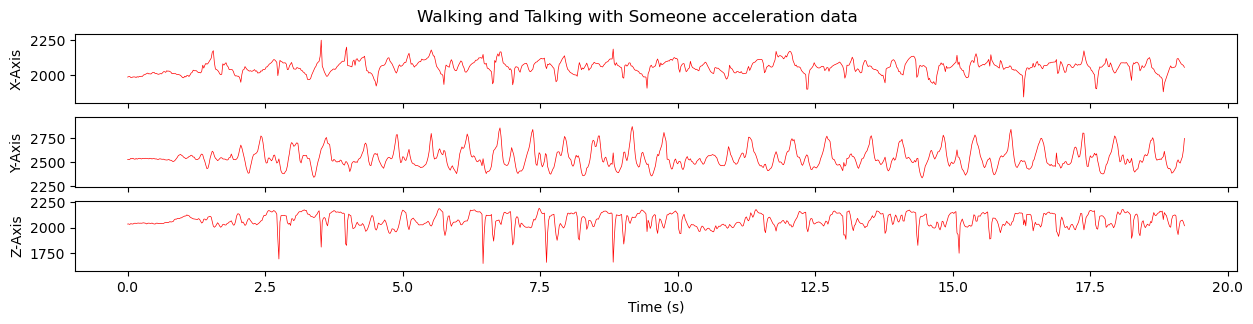

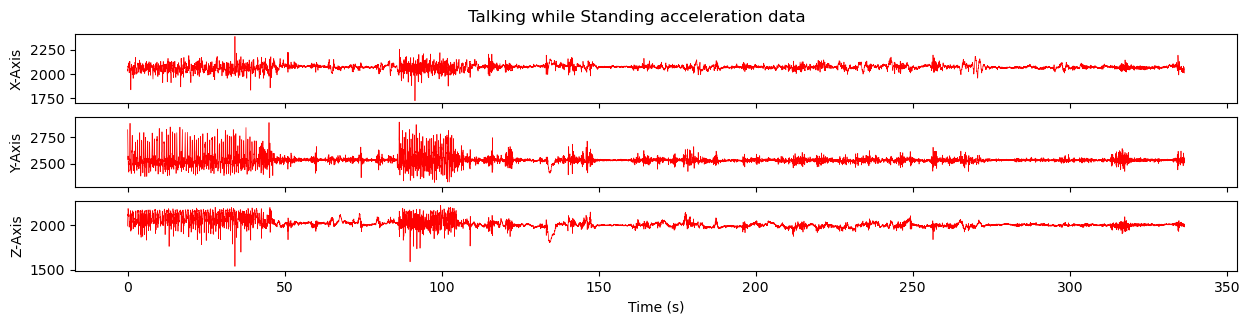

In [7]:
for activity_number in range(1, 8):
    plot_activity(ACTIVITY_LABELS[activity_number], participant_df[participant_df['label'] == activity_number])

Given the varying lengths of data sets related to each activity, we choose the window size for comparison to be the size of the data set with the fewest observations.

In [8]:
window_size = min(len(participant_df[participant_df['label'] == activity_number]['x']) for activity_number in range(1, 8))
window_size

1000

## Code Implementation

### Wavelet Visualization

Visualize all the possible families of continuous wavelet functions implemented in PyWavelets:

c:\Users\giuli\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\giuli\AppData\Local\Temp\ipykernel_36196\4064253734.py:6: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = pywt.ContinuousWavelet(wavelet_name)
C:\Users\giuli\AppData\Local\Temp\ipykernel_36196\4064253734.py:6: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = pywt.ContinuousWavelet(wavelet_name)
C:\Users\giuli\AppData\Local\Temp\ipyker

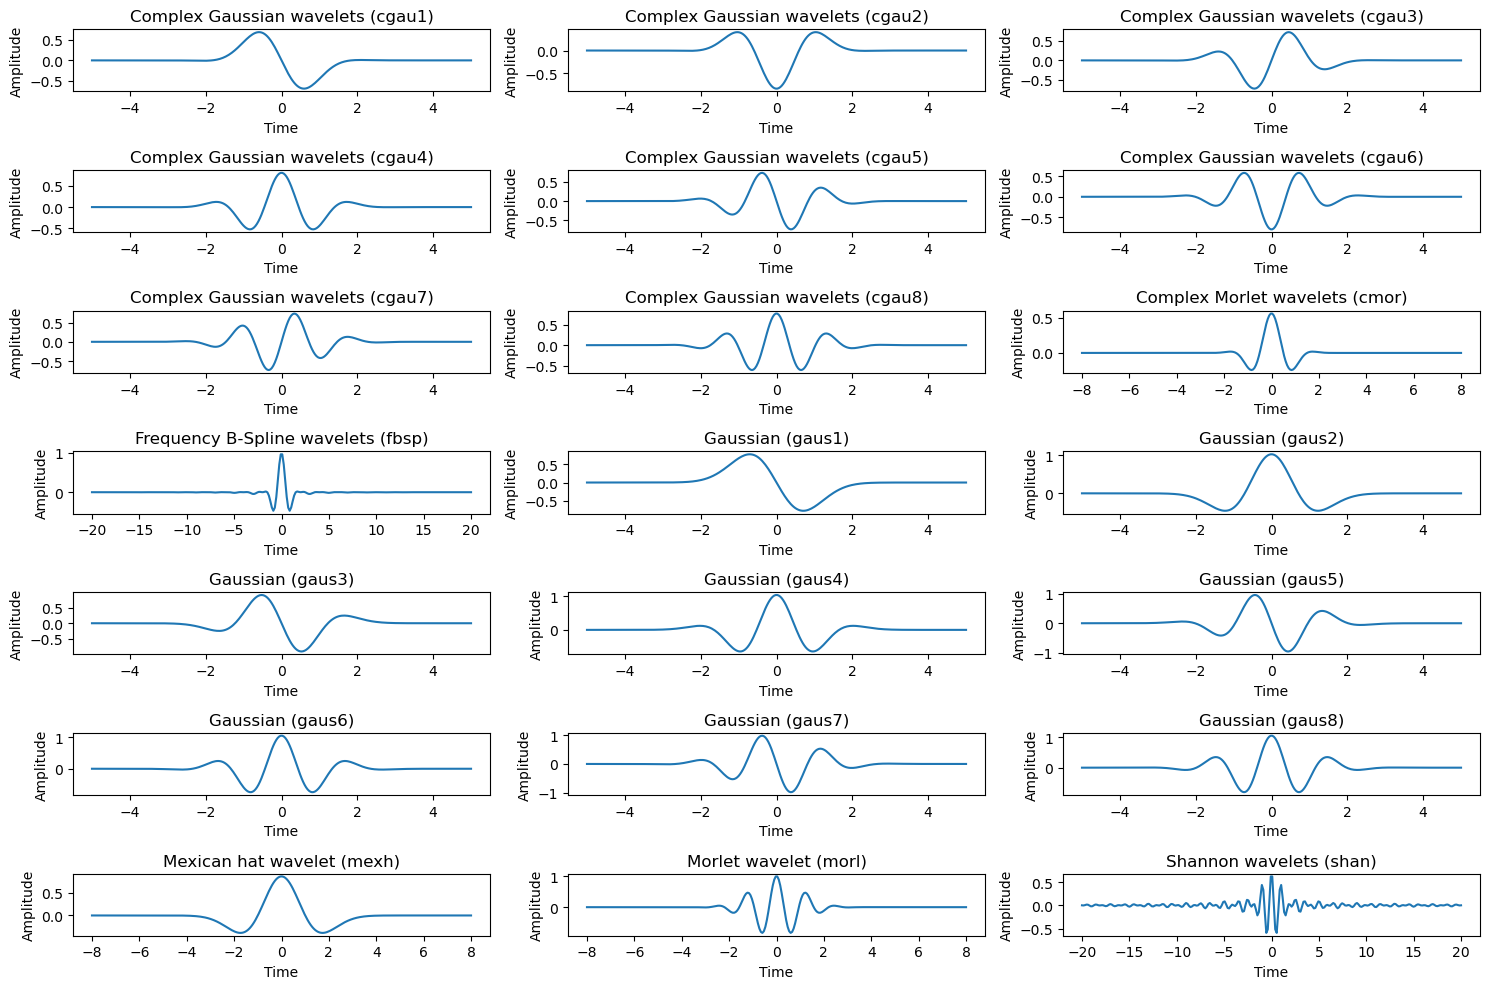

In [9]:
# Plot wavelet functions for each family
plt.figure(figsize=(15, 10))
num_wavelets = len(pywt.wavelist(kind='continuous'))

for wavelet_name in pywt.wavelist(kind='continuous'):
    wavelet = pywt.ContinuousWavelet(wavelet_name)
    # Compute wavelet function
    psi, x = wavelet.wavefun()
    plt.subplot(num_wavelets // 3, 3, pywt.wavelist(kind='continuous').index(wavelet_name) + 1)
    plt.plot(x, psi)
    plt.title(wavelet.family_name+' ('+wavelet_name+')')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [10]:
def visualize_wavelet(wavelet_name, scales=2**np.arange(1, 8)):
    """
    Visualize the wavelet and its frequency response.

    Args:
        wavelet_name (str): Name of the wavelet to visualize.
        scales (ndarray, optional): Array of scales to visualize the wavelet at. 
            Defaults to 2**np.arange(1, 8).
    """
    wav = pywt.ContinuousWavelet(wavelet_name)
    width = wav.upper_bound - wav.lower_bound

    max_len = int(np.max(scales)*width + 1)
    t = np.arange(max_len)
    fig, ax = plt.subplots(len(scales), 2, figsize=(15, 10))
    for n, scale in enumerate(scales):
        int_psi, x = pywt.integrate_wavelet(wav, precision=10)
        step = x[1] - x[0]
        j = np.floor(np.arange(scale * width + 1) / (scale * step))
        if np.max(j) >= np.size(int_psi):
            j = np.delete(j, np.where(j >= np.size(int_psi))[0])
        j = j.astype(np.int_)

        # normalize int_psi for easier plotting
        int_psi /= np.abs(int_psi).max()

        # discrete samples of the integrated wavelet
        filt = int_psi[j][::-1]

        # plot CWT (convolution of filt with the signal) at each scale
        nt = len(filt)
        t = np.linspace(-nt//2, nt//2, nt)
        ax[n, 0].plot(t, filt.real, t, filt.imag) # real and imaginary parts of the filter
        ax[n, 0].set_ylim([-1, 1])
        ax[n, 0].set_title(f'Filter (scale = {scale})')

        f = np.linspace(-np.pi, np.pi, max_len)
        filt_fft = np.fft.fftshift(np.fft.fft(filt, n=max_len))
        filt_fft /= np.abs(filt_fft).max()
        ax[n, 1].plot(f, np.abs(filt_fft)**2) # power spectrum
        ax[n, 1].set_xlim([-np.pi, np.pi])
        ax[n, 1].set_xticks([-np.pi, 0, np.pi])
        ax[n, 1].set_title(f'|FFT(filter)|$^2$ (scale = {scale})') # filter frequency transform
        ax[n, 1].set_xticklabels(['$-\pi$', '0', '$\pi$'])
        ax[n, 1].grid(True, axis='x')

    ax[n, 0].set_xlabel('time (samples)')
    ax[n, 1].set_xlabel('frequency (radians)')
    ax[0, 0].legend(['real', 'imaginary'], loc='upper left')
    ax[0, 1].legend(['Power'], loc='upper left')

    fig.suptitle(f'Wavelet filter and its frequency response, {wav.family_name}')
    fig.tight_layout()
    plt.show()

We choose to use the Complex Morlet wavelet with a bandwidth frequency of 1.5 and a center frequency of 1.0 (value suggested by the PyWavelet library) for our analysis.

For visualization purposes, we plot the wavelet function and its frequency response at various scales.

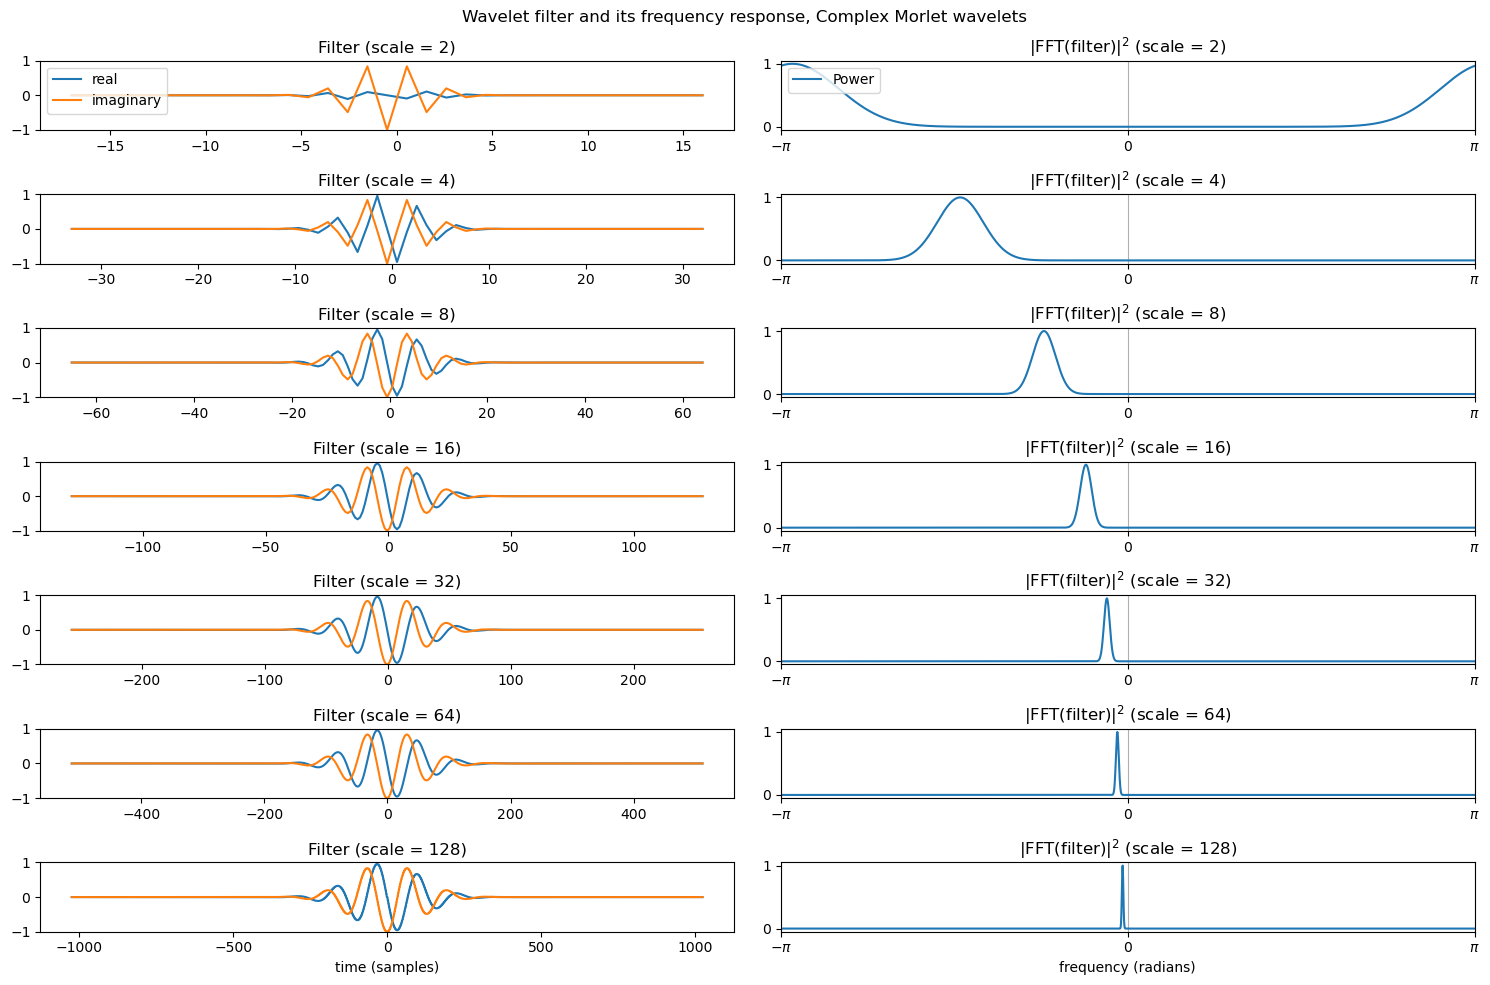

In [11]:
wavelet_name = 'cmor1.5-1.0' # Complex Morlet wavelet with omega0=1.5 and gamma=1.0
scales_to_visualize = 2**np.arange(1, 8)

visualize_wavelet(wavelet_name=wavelet_name, scales=scales_to_visualize)

### Continuous Wavelet Transform

In [12]:
def compute_continuous_wavelet_transform(data_df, wavelet_name, scales):
    """
    Computes the continuous wavelet transform of the given data using the given wavelet and scales.

    Args:
        data_df (DataFrame): The data for which the continuous wavelet transform is to be computed.
        wavelet_name (str): The wavelet to be used for the continuous wavelet transform.
        scales (ndarray): The scales to be used for the continuous wavelet transform.

    Returns:
        cwtmatr (ndarray): The continuous wavelet transform matrix.
        freqs (ndarray): The frequencies corresponding to the wavelet transform.
    """
    cwtmatr, freqs = pywt.cwt(data_df, scales, wavelet_name)
    return cwtmatr, freqs

def plot_continuous_wavelet_transform(activity, data_df, cwtmatr_list, scales):
    """
    Plots the continuous wavelet transform of the acceleration data for the given activity.

    Args:
        activity (str): The activity for which the continuous wavelet transform is to be plotted.
        data_df (DataFrame): The data for the given activity.
        cwtmatr_list (list): The list of continuous wavelet transform matrices for the three axes.
        scales (ndarray): The scales to be used for the continuous wavelet transform.
    """
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    axis_list = ['X', 'Y', 'Z']
    ax = ax.ravel()
    for i in range(3):
        cwtmatr_abs = np.abs(cwtmatr_list[i][:-1, :-1]) # taking the absolute value of the cwt matrix
        ax[i].imshow(cwtmatr_abs, extent=[0, len(data_df)/SAMPLING_FREQUENCY, 1, max(scales)], aspect='auto', cmap='jet',
            norm=plt.cm.colors.Normalize(vmin=0, vmax=2*np.sqrt(np.max(cwtmatr_abs))))
        ax[i].set_title(f'Axis {axis_list[i]}', fontsize=10)
        ax[i].set_ylabel('Scale')
        ax[i].set_xlabel('Time (s)')
    fig.colorbar(ax[1].get_images()[0], ax=ax, orientation='horizontal', label='CTW Coefficient', pad=0.2, aspect=80)
    fig.suptitle('Continuous Wavelet Transform of acceleration data for {}'.format(activity))
    plt.show()

In [13]:
def wavelet_transform_per_activity(df, wavelet_name, scales, window_size):
    """
    Compute the continuous wavelet transform for each activity and plot the results.

    Args:
        df (DataFrame): Dataframe containing the acceleration data.
        wavelet_name (str): Name of the wavelet to use.
        scales (ndarray): Scales to use in the CWT.
        window_size (int): Size of the window for each activity.
    """
    for activity_number in range(1, 8):
        cwtmatr_list = []
        freqs_list = []
        for axis in ['x', 'y', 'z']:
            # use window_size samples for each activity, centered around the middle of the activity
            dim = len(df[df['label'] == activity_number][axis].values)
            data_df = df[df['label'] == activity_number][axis].values[dim//2 - window_size//2:dim//2 + window_size//2]

            cwtmatr, freqs = compute_continuous_wavelet_transform(data_df, wavelet_name, scales)
            cwtmatr_list.append(cwtmatr)
            freqs_list.append(freqs)
        # coeficient plot
        plot_continuous_wavelet_transform(ACTIVITY_LABELS[activity_number], 
            df[df['label'] == activity_number].values[:window_size], cwtmatr_list, scales)

In [14]:
def visualize_wavelet_transform(df, wavelet_name, scales): 
    """
    Compute and visualize the continuous wavelet transform of the acceleration data.

    Args:
        df (DataFrame): Dataframe containing the acceleration data.
        wavelet_name (str): Name of the wavelet to use.
        scales (ndarray): Scales to use in the CWT.
    """
    for axis in ['x', 'y', 'z']:
        data_df = df[axis].values
        cwtmatr, freqs = compute_continuous_wavelet_transform(data_df, wavelet_name, scales)

        # plot coeficients
        plt.figure(figsize=(15, 4))
        cwtmatr_abs = np.abs(cwtmatr[:-1, :-1])
        plt.imshow(cwtmatr_abs, extent=[0, len(data_df)/SAMPLING_FREQUENCY, 1, max(scales)], aspect='auto', cmap='jet',
            norm=plt.cm.colors.Normalize(vmin=0, vmax=2*np.sqrt(np.max(cwtmatr_abs))))

        # add line between the coeficients of each activity
        x_activity = [len(participant_df[participant_df['label'] == activity_number]['x'])/SAMPLING_FREQUENCY 
            for activity_number in range(1, 8)]
        x_activity = np.cumsum(x_activity)
        for i in range(0, len(x_activity)):
            plt.plot(np.ones(int(max(scales)))*x_activity[i], np.arange(1, int(max(scales))+1), 
            color='black', linewidth=1.5)
        
        plt.title(f'Continuous Wavelet Transform of acceleration data, Axis {axis}')
        plt.ylabel('Scale')
        plt.xlabel('Time (s)')
        plt.colorbar(orientation='horizontal', label='CTW Coefficient', pad=0.2, aspect=80)
        plt.show()

## Results

In order to compare the continuous wavelet transformations of different activities, we standardized the comparison by utilizing a window size equal to the size of the dataset with the fewest observations, thereby considering time series of equal length. This was achieved by extracting the central portion of each time series.

Visualize the power-spectrum of the signals for the different activities, revealed by the wavelet transform:

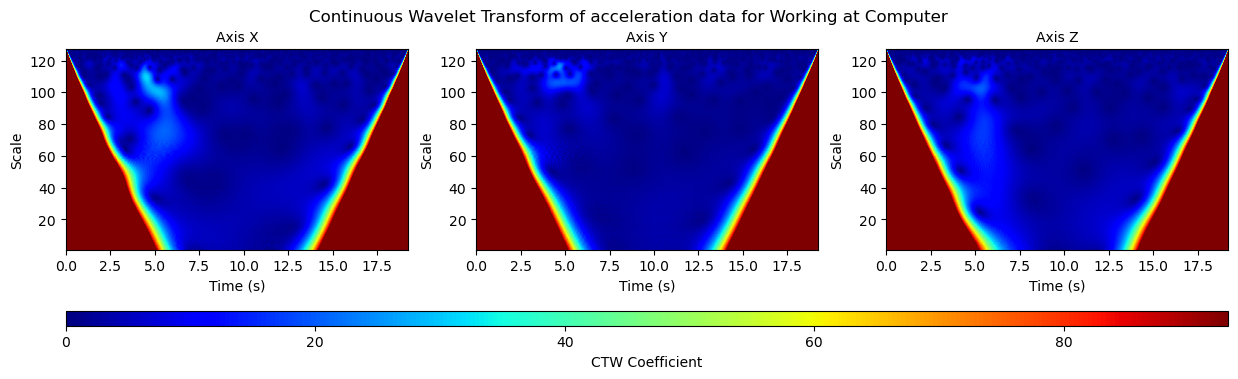

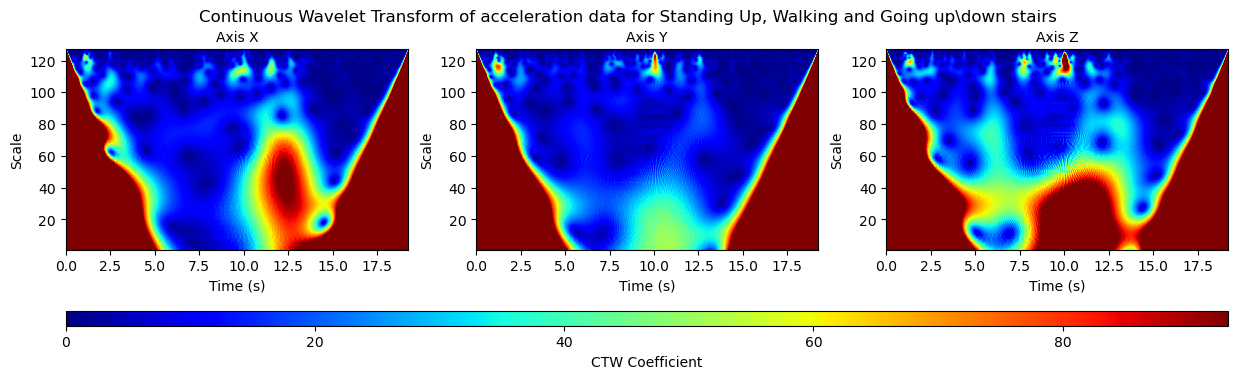

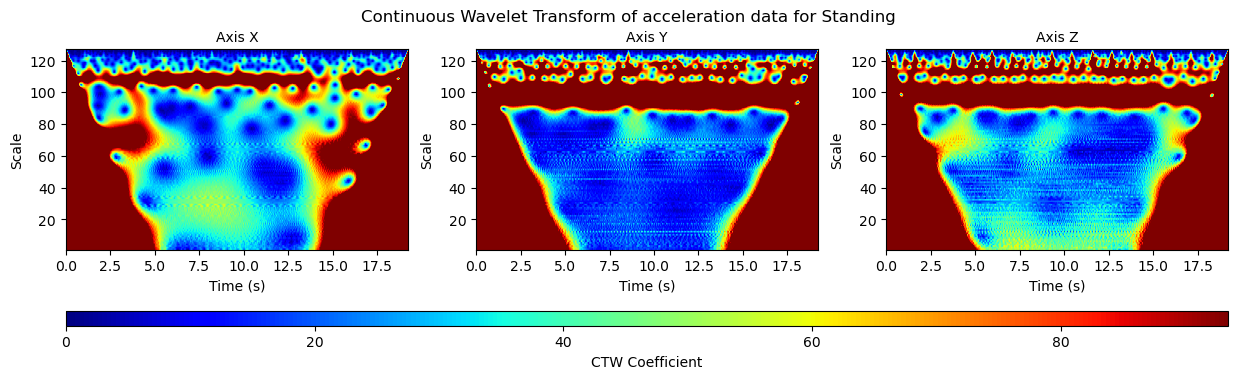

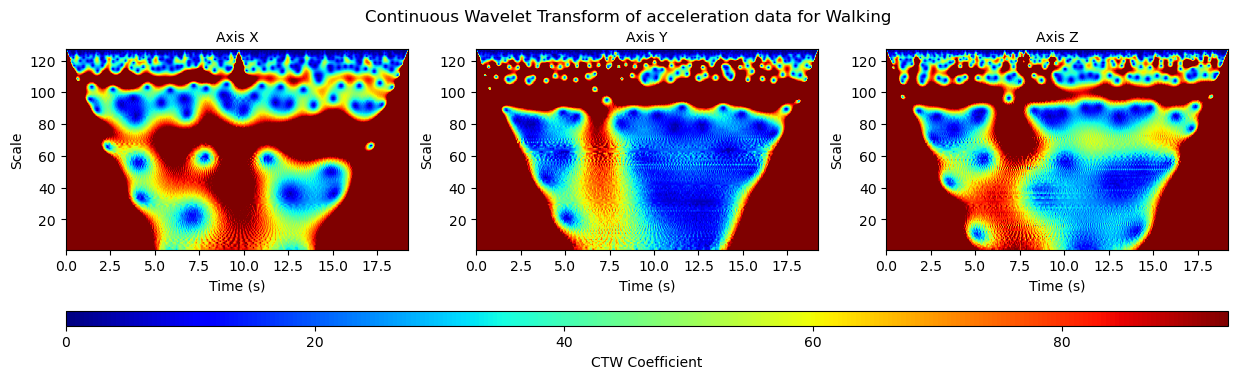

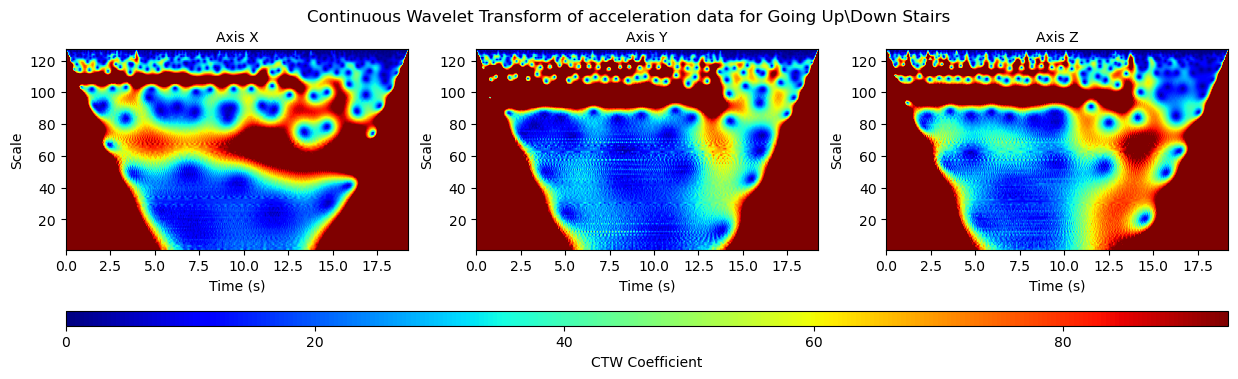

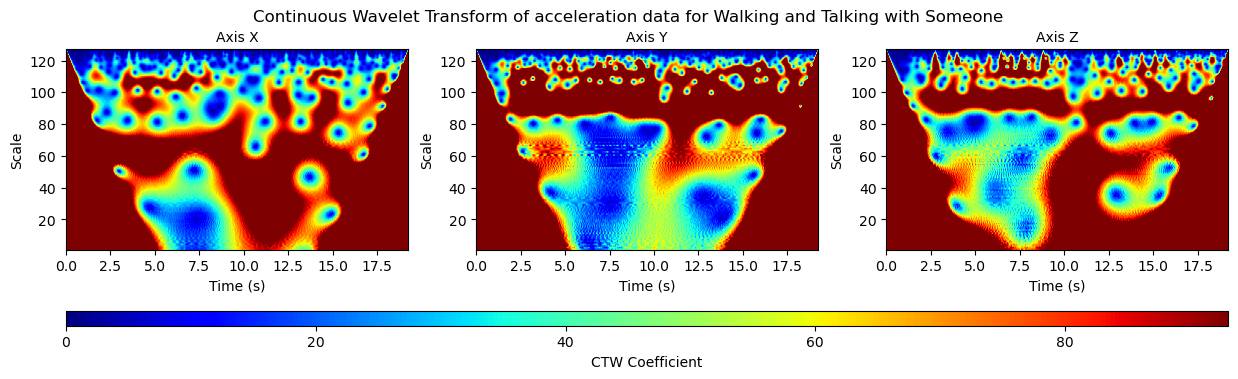

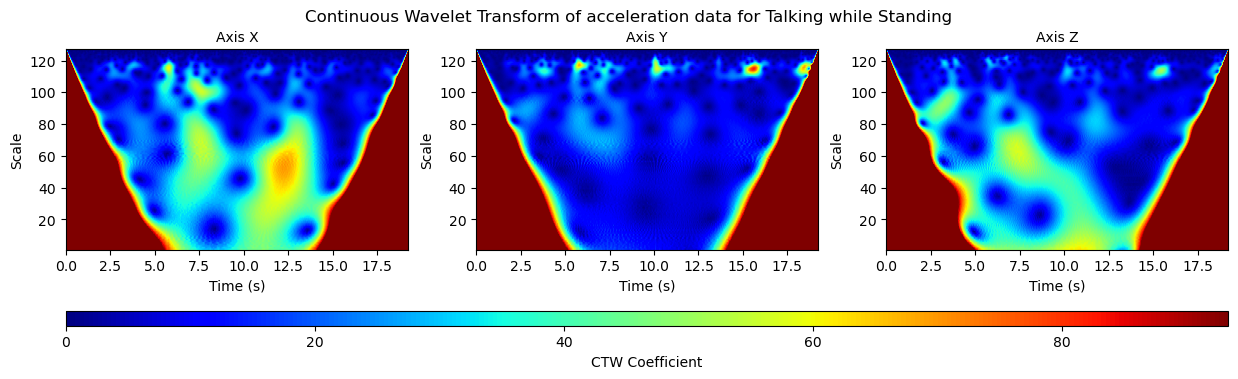

In [15]:
scales = np.arange(1, 128)
wavelet_transform_per_activity(participant_df, wavelet_name=wavelet_name, scales=scales, window_size=window_size)

In order to facilitate visual comparison, note that the plotted coefficient are normalized and the colorbar is consistent across all plots.

We also computed the continuous wavelet transform considering the entire set of activities as a single time series (one for each axis) and visualized the spectrograms below. 

The vertical black lines represent the divisions between the various activities
('Working at Computer', 'Standing Up, Walking and Going up/down stairs', 'Standing', 'Walking', 'Going Up/Down Stairs', 'Walking and Talking with Someone', 'Talking while Standing').

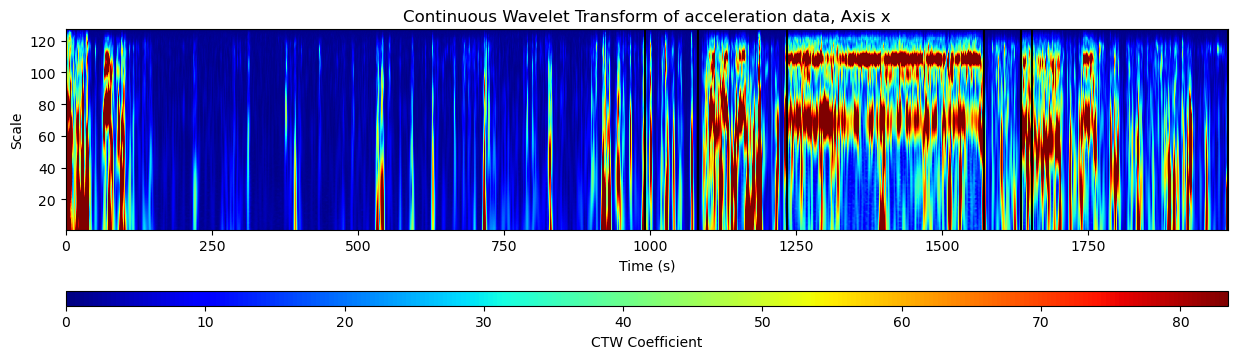

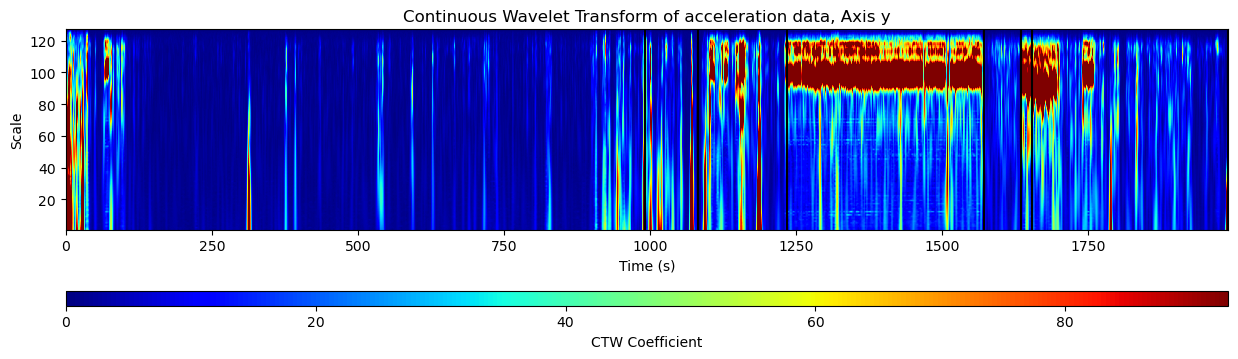

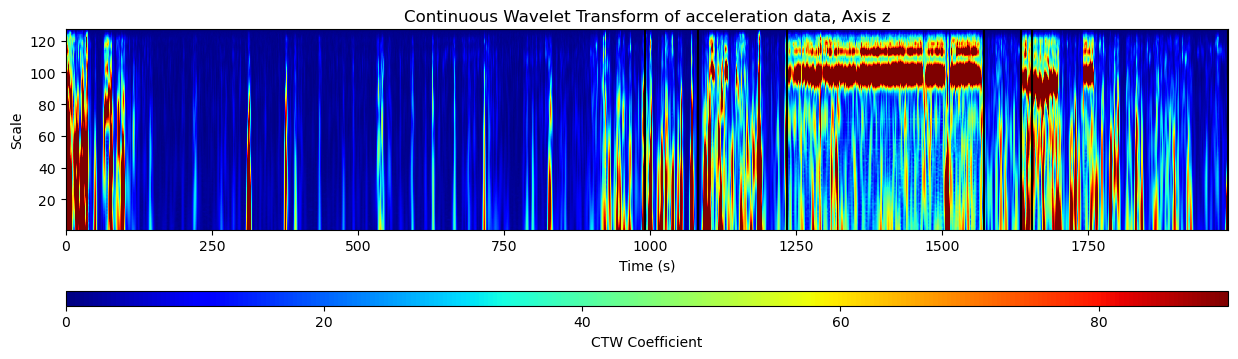

In [16]:
visualize_wavelet_transform(participant_df, wavelet_name=wavelet_name, scales=scales)

### Conclusion

Below is the analysis of the spectrogram derived from the continuous wavelet transformations of time series data related to various activities:

- **Working at Computer**:
   - The signal appears flat with consistently low coefficient values, which was expected given the sedentary nature of this activity.
   - The selected time window for comparison showed a flat signal in the initial plots of the data.
   - However, when observing the spectrogram representing the CWT of the entire data sequence, an event is highlighted at the initial moments. This event stands out compared to others, indicating a noticeable variation in accelerometer data during that time window, possibly suggesting a movement such as standing up.

- **Talking while Standing**:
   - Similar to working at a computer, although instances with slightly higher coefficient values are observable, especially on the x and z axes, possibly indicating minor movements while standing still.
   - In the initial portion of the time series, it detects some events with higher coefficients compared to the rest, both at high and low frequencies, suggesting that at the beginning of the experiment the individual was not entirely still.

- **Standing**:
   - The selected time window for comparison shows high coefficients at high scales, effectively capturing low frequencies.
   - On the x-axis, it also manages to detect small events at lower scales, suggesting slight movements rather than complete stillness throughout the entire time frame.

- **Walking** and **Walking and Talking with Someone**:
   - Spectrograms for these two activities exhibit similar patterns, with various distinct events and numerous points showing higher coefficient values, particularly noticeable at higher frequency scales.
   - For *Walking and Talking with Someone*, higher coefficients are observed in relation to high frequencies on the z-axis compared to *Walking*.
   - Differentiating between these activities based solely on the spectrogram visualization is challenging.

- **Going Up/Down Stairs**:
   - This activity displays the highest coefficients at low frequencies throughout the entire time series.
   - Additionally, events with higher coefficients are detectable halfway through the chosen scale, especially noticeable on the x-axis.
   - Solely based on the spectrograms, this activity is the most easily identifiable compared to others.


- **Standing Up, Walking and Going up/down stairs**:
   - In the comparison window, it initially detects low coefficients for high frequencies (likely indicating stillness), but from 11 seconds onwards, it detects high frequencies on the x and z axes (similar to Going up/down stairs).
   - Upon observing the spectrogram derived from the entire time series, three particularly distinct events are noticeable (with higher coefficients compared to the rest, both at high and low frequencies). These events could correspond to moments when the subject is *Going up/down stairs*, while others may reflect behaviors analogous to the time series of *Standing* and *Walking*. 

## Final Considerations

In summary, the spectrograms provide valuable insights into the temporal and frequency characteristics of diverse activities.

While certain activities, such as *Walking* and *Walking and Talking with Someone*, cannot be distinguished from each other solely based on the spectrogram, we can still observe visible differentiation between activities that mostly involve staying still compared to those where the subject is in motion.

Clear differentiation between specific activities within the dataset based solely on the continuous wavelet transformations is not straightforward.

Moreover, the presence of labels containing more than one activity and the overlapping between some labels add complexity to the analysis.

Therefore, while the spectrograms provide useful information, precise activity identification through CWT alone remains challenging.

Considering additional data from other participants may allow for a more detailed analysis and facilitate a more comprehensive comparison of time series with same label but originating from different individuals.